# Subclass DE BAD

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [4]:
gene =    anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")

In [5]:
gene

AnnData object with n_obs × n_vars = 6160 × 19190
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'
    obsp: 'connectivities', 'distances'

In [6]:
gene = gene[:,gene.var.sort_index().index]

In [7]:
print(gene.shape)

(6160, 19190)


In [8]:
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')



def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, method):
    nfeat = pval.shape[1]
    
    if method == 'benjamini-hochberg':
        _, pval_corr, _, _ = multipletests(pval, alpha=0.01, method='fdr_bh')
    elif method == 'bonferroni':
        pval_corr = np.minimum(pval * nfeat, 1.0)
        
    return pval_corr

def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)

    for tidx, t in enumerate(unique):
        logging.debug("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)
        
        pvalue = np.nan
        statistic = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        # added

        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate", equal_var=False)
            pvalue = test.pvalue
            statistic = test.statistic
                
        pval[tidx,:][mask] = pvalue
        stat[tidx,:][mask] = statistic
    
    return (pval, stat)

In [9]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
gene_features = gene.var.index.values
assignments   = gene.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_gene_raw, stat = dexpress(mat, components, gene_features, assignments, 
                      nan_cutoff=nan_cutoff)

p_gene = correct_pval(p_gene_raw/2, corr_method)
s_gene = stat

23-Oct-20 08:29:01 - 1 of 18 assignments: Astro
23-Oct-20 08:29:07 - 2 of 18 assignments: Endo
23-Oct-20 08:29:08 - 3 of 18 assignments: L2/3 IT
23-Oct-20 08:29:09 - 4 of 18 assignments: L5 IT
23-Oct-20 08:29:10 - 5 of 18 assignments: L5 PT
23-Oct-20 08:29:11 - 6 of 18 assignments: L5/6 NP
23-Oct-20 08:29:12 - 7 of 18 assignments: L6 CT
23-Oct-20 08:29:13 - 8 of 18 assignments: L6 IT
23-Oct-20 08:29:14 - 9 of 18 assignments: L6 IT Car3
23-Oct-20 08:29:15 - 10 of 18 assignments: L6b
23-Oct-20 08:29:16 - 11 of 18 assignments: Lamp5
23-Oct-20 08:29:16 - 12 of 18 assignments: Low Quality
23-Oct-20 08:29:17 - 13 of 18 assignments: Pvalb
23-Oct-20 08:29:18 - 14 of 18 assignments: SMC
23-Oct-20 08:29:18 - 15 of 18 assignments: Sncg
23-Oct-20 08:29:19 - 16 of 18 assignments: Sst
23-Oct-20 08:29:20 - 17 of 18 assignments: VLMC
23-Oct-20 08:29:20 - 18 of 18 assignments: Vip


CPU times: user 7.83 s, sys: 15.9 s, total: 23.8 s
Wall time: 23.8 s


In [10]:
p1 = p_gene
s1 = stat

In [11]:
alpha = 0.01
tcrit = 0


bool_mask = np.ones(p1.shape, dtype=bool)

p1_mask = np.logical_and(p1<alpha, s1>tcrit)

bool_mask = p1_mask

In [12]:
bool_mask.sum()

19473

In [13]:
assignments = gene.obs.subclass_label.values
unique = np.unique(assignments)

In [14]:
unique

array(['Astro', 'Endo', 'L2/3 IT', 'L5 IT', 'L5 PT', 'L5/6 NP', 'L6 CT',
       'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Low Quality', 'Pvalb',
       'SMC', 'Sncg', 'Sst', 'VLMC', 'Vip'], dtype=object)

In [15]:
markers_gene = pd.DataFrame(index=unique, columns=["gene_name", "p_raw", "p_bonferroni"])

In [16]:
gene_features = gene.var.gene_name.values

for uidx, u in enumerate(unique):
    mask = bool_mask[uidx] # np.logical_and(bool_mask[uidx], bool_mask.sum(axis=0)==1)
    
    p = p_gene[uidx][mask]
    p_raw = p_gene_raw[uidx][mask]
    
    psort = np.argsort(p)
    
    fsorted = gene_features[mask][psort]
    psorted = p[psort]
    p_raw_sorted = p_raw[psort]
    
    markers_gene.loc[u]["gene_name"] = fsorted
    markers_gene.loc[u]["p_raw"] = p_raw_sorted
    markers_gene.loc[u]["p_bonferroni"] = psorted

In [17]:
markers_gene

,gene_name,p_raw,p_bonferroni
Astro,[],[],[]
Endo,"[Vamp8_ENSMUSG00000050732, Ly6a_ENSMUSG0000007...","[2.022278385468801e-10, 3.9596077100262786e-10...","[1.9403761108573147e-06, 3.7992435977702143e-0..."
L2/3 IT,"[Ptk2b_ENSMUSG00000059456, Camk2n1_ENSMUSG0000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
L5 IT,"[Rprml_ENSMUSG00000046215, Camk2n1_ENSMUSG0000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
L5 PT,"[Igfbp6_ENSMUSG00000023046, Gm13306_ENSMUSG000...","[6.018272301539206e-16, 5.469719550860107e-14,...","[5.774532273326869e-12, 5.248195909050273e-10,..."
L5/6 NP,"[Nrsn2_ENSMUSG00000059361, Gm13306_ENSMUSG0000...","[0.0, 0.0, 0.0, 0.0, 2.0972207605900295e-301, ...","[0.0, 0.0, 0.0, 0.0, 2.0122833197861334e-297, ..."
L6 CT,"[Gm13306_ENSMUSG00000073877, Fxyd7_ENSMUSG0000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
L6 IT,"[Fhl2_ENSMUSG00000008136, Enc1_ENSMUSG00000041...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
L6 IT Car3,"[Pih1d1_ENSMUSG00000003423, Arhgdig_ENSMUSG000...","[1.92944259303629e-11, 1.1536524724119812e-09,...","[1.8513001680183204e-07, 1.106929547279296e-05..."
L6b,"[Gabra5_ENSMUSG00000055078, Serpini1_ENSMUSG00...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
gene.obs.subclass_label.value_counts()

L5 IT          1561
L6 CT           904
Vip             607
L6b             570
Pvalb           521
L2/3 IT         482
Sst             406
L6 IT           395
Lamp5           360
L5/6 NP         207
Sncg             77
SMC              19
L5 PT            12
Low Quality      12
Astro             9
Endo              7
VLMC              6
L6 IT Car3        5
Name: subclass_label, dtype: int64

In [19]:
specific_cluster = "L5 PT"
specific_gene = "Sept4_ENSMUSG00000020486"

In [20]:
specific_gene

'Sept4_ENSMUSG00000020486'

In [21]:
logger.setLevel(logging.ERROR)

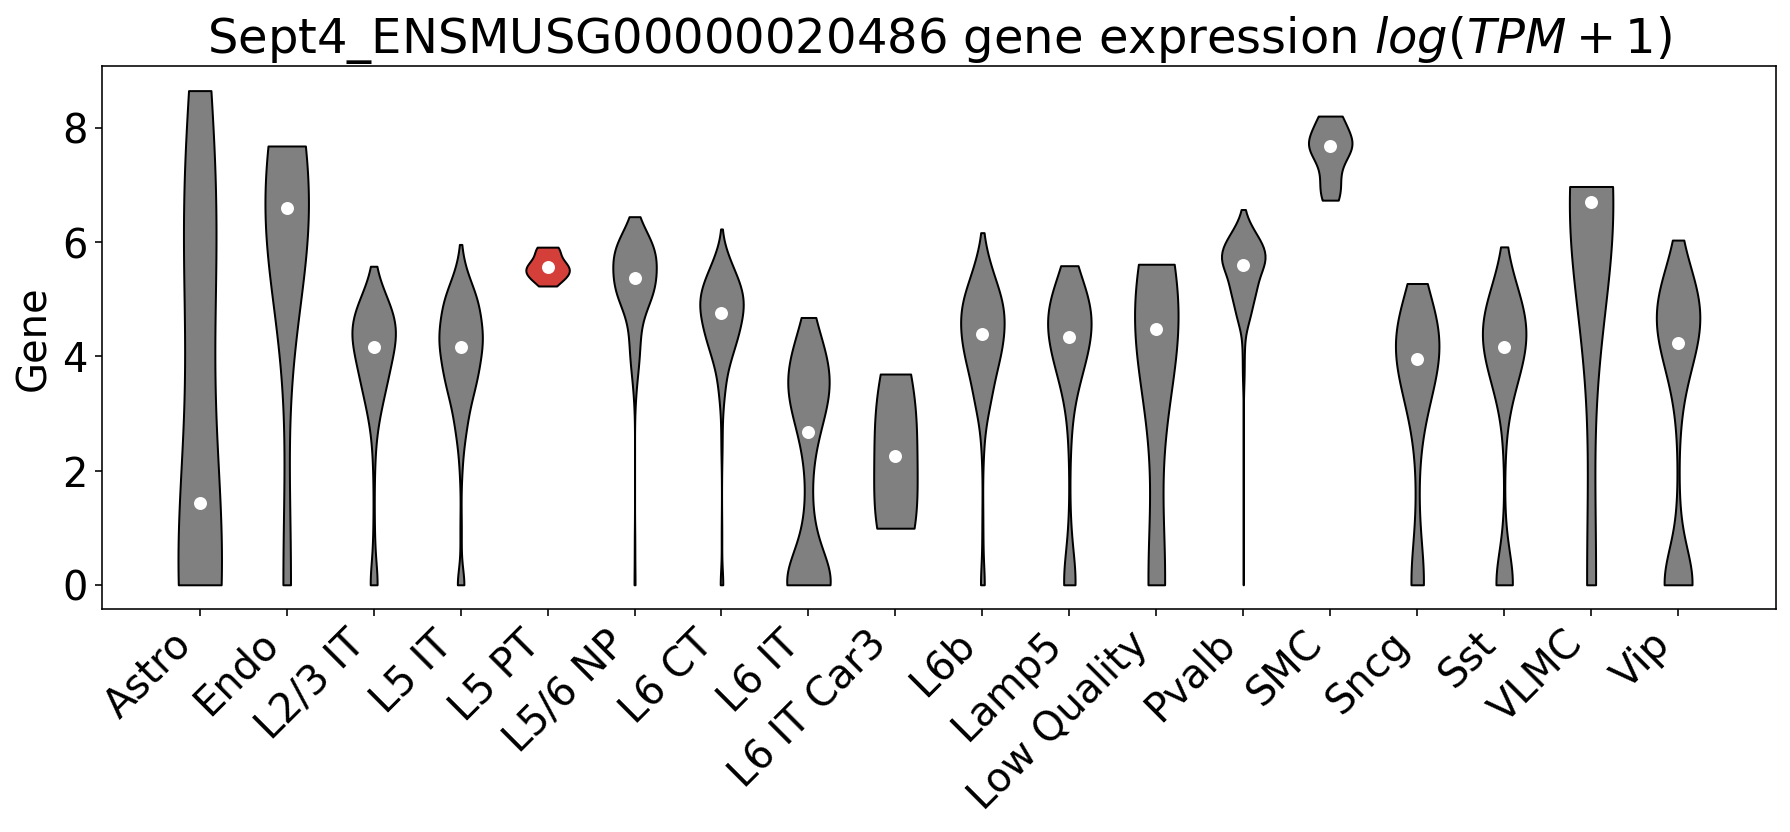

In [22]:
fig, ax = plt.subplots(figsize=(15,5))
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene.obs.subclass_label.values)


labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.subclass_label==c][:,gene.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax.violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

medians = [np.median(i) for i in x]
ax.scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

#ax[0].axhline(y=medians[midx], color="k", linestyle="--")
ax.set_ylabel("Gene")


medians = [np.median(i) for i in x]
ax.set_xticks(lidx)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_title("{} gene expression $log(TPM + 1)$".format(specific_gene))
#plt.savefig("./figures/class_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [23]:
identified_genes = markers_gene["gene_name"].explode().astype(str)
identified_genes = identified_genes[identified_genes!="nan"]

In [24]:
print("{} genes identified.".format(identified_genes.nunique()))

6948 genes identified.


In [25]:
markers_gene["gene_name"].explode()

Astro                           NaN
Endo       Vamp8_ENSMUSG00000050732
Endo        Ly6a_ENSMUSG00000075602
Endo       Ly6c1_ENSMUSG00000079018
Endo        Emcn_ENSMUSG00000054690
                    ...            
Vip      Olfr344_ENSMUSG00000096822
Vip         Ccnh_ENSMUSG00000021548
Vip       Arglu1_ENSMUSG00000040459
Vip        Dpy30_ENSMUSG00000024067
Vip      Gm28268_ENSMUSG00000101776
Name: gene_name, Length: 19474, dtype: object

In [26]:
markers_gene["p_raw"].explode()

Astro            NaN
Endo     2.02228e-10
Endo     3.95961e-10
Endo     1.01549e-09
Endo     3.09878e-09
            ...     
Vip      7.92835e-07
Vip      8.07487e-07
Vip       8.5497e-07
Vip      9.26332e-07
Vip      9.61388e-07
Name: p_raw, Length: 19474, dtype: object

In [27]:
markers_gene = markers_gene.apply(pd.Series.explode).reset_index()

In [28]:
markers_gene

,index,gene_name,p_raw,p_bonferroni
0,Astro,NaN,NaN,NaN
1,Endo,Vamp8_ENSMUSG00000050732,2.02228e-10,1.94038e-06
2,Endo,Ly6a_ENSMUSG00000075602,3.95961e-10,3.79924e-06
3,Endo,Ly6c1_ENSMUSG00000079018,1.01549e-09,9.74358e-06
4,Endo,Emcn_ENSMUSG00000054690,3.09878e-09,2.97328e-05
...,...,...,...,...
19469,Vip,Olfr344_ENSMUSG00000096822,7.92835e-07,0.00760725
19470,Vip,Ccnh_ENSMUSG00000021548,8.07487e-07,0.00774784
19471,Vip,Arglu1_ENSMUSG00000040459,8.5497e-07,0.00820343
19472,Vip,Dpy30_ENSMUSG00000024067,9.26332e-07,0.00888816


In [29]:
markers_gene.to_csv("../../tables/unordered/union_test_subclass_DE_bad.csv")

In [30]:
markers_gene

,index,gene_name,p_raw,p_bonferroni
0,Astro,NaN,NaN,NaN
1,Endo,Vamp8_ENSMUSG00000050732,2.02228e-10,1.94038e-06
2,Endo,Ly6a_ENSMUSG00000075602,3.95961e-10,3.79924e-06
3,Endo,Ly6c1_ENSMUSG00000079018,1.01549e-09,9.74358e-06
4,Endo,Emcn_ENSMUSG00000054690,3.09878e-09,2.97328e-05
...,...,...,...,...
19469,Vip,Olfr344_ENSMUSG00000096822,7.92835e-07,0.00760725
19470,Vip,Ccnh_ENSMUSG00000021548,8.07487e-07,0.00774784
19471,Vip,Arglu1_ENSMUSG00000040459,8.5497e-07,0.00820343
19472,Vip,Dpy30_ENSMUSG00000024067,9.26332e-07,0.00888816
